# Covid Classification Task

## Data Loading and Preparation

In [2]:
import numpy as np
import pandas as pd
import sklearn
import os
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Old Dataset

In [3]:
# import old dataset
df_old = pd.read_csv('input/Yawen-Colonoscopy-Covid Data files/covid-19/covid19_complete_feature&annotation.csv')
df_old.head()

,id,recommendation_expert,recommendation_consumer_1,recommendation_consumer_2,undersitandability_expert,medically_informative_expert,information_accuracy_expert,understandability_consumer_1,medical_information_consumer_1,understandability_consumer_2,...,dislikeRate,commentCount,favoriteCount,channelSubscriberCount,channelViewCount,channelCount,channelVideoCount,max_cos_sim_des,max_cos_sim_title,max_cos_sim_tran
0,0pVEO0bkreA.mp4,1,1,0,1,0,1,1,0,0,...,0.000000,0,0,0,1595676,0,250,0.316228,0.353553,0.000000
1,UEoWRXJT_4I.mp4,0,0,1,1,0,0,1,0,1,...,0.000000,0,0,11600,1290325,0,1411,0.280056,0.333333,0.000000
2,1mKITi1D0p0.mp4,1,1,1,1,1,1,1,1,1,...,0.000309,0,0,13200,25348907,0,712,0.000000,0.577350,0.069505
3,7tgm8KBlCtE.mp4,1,1,1,1,1,1,1,1,1,...,0.000428,29,0,796,841142,0,1043,0.190693,0.353553,0.080064
4,1Yn0pk22pVM.mp4,1,1,1,1,1,1,1,1,1,...,0.000300,0,0,123000,70006556,0,1523,0.190117,0.377964,0.123797


### New Dataset

In [4]:
# concat label to the new dataset
id = df_old["id"].values.tolist()
label = df_old["recommendation_expert"].values.tolist()
covid_dict = dict(list(zip(id, label)))
data_list = []
for filename in os.listdir('temp/covid-feature'):
    id = filename.split(".")[0] + '.mp4'
    if id in covid_dict.keys():
        file_path = os.path.join('temp/covid-feature', filename)
        with open(file_path, 'r') as f:
            data = json.load(f)
        data['label'] = covid_dict[id]
        data_list.append(data)    
df_new = pd.DataFrame(data_list)
df_new['channel_subscribers'] = df_new['channel_subscribers'].astype(int)
df_new.head()
print(df_new.shape)

(292, 30)


## Classification

### Classification Model for old dataset

In [5]:
df_old.columns

Index(['id', 'recommendation_expert', 'recommendation_consumer_1',
       'recommendation_consumer_2', 'undersitandability_expert',
       'medically_informative_expert', 'information_accuracy_expert',
       'understandability_consumer_1', 'medical_information_consumer_1',
       'understandability_consumer_2', 'medical_information_consumer_2',
       'OCR_confidence_google', 'active_verb_google', 'readability_google',
       'sentence_count_google', 'shot_count_google',
       'shotchange_confidence_google', 'summary_words_google',
       'transcript_confidence_google', 'transition_words_google',
       'word_count_google', 'word_unique_google', 'title_x', 'has_title_meta',
       'has_description_meta', 'has_tags_meta', 'readability_meta',
       'sentence_count_meta', 'word_count_meta', 'word_unique_meta',
       'transition_words_meta', 'summary_words_meta', 'active_verb_meta',
       'video_duration_meta', 'medically_unique', 'likeRate', 'dislikeRate',
       'commentCount', 'fav

In [12]:
# count the number of missing values in each column
missing_counts = df_old.isna().sum()
print(missing_counts)

id                                0
recommendation_expert             0
recommendation_consumer_1         0
recommendation_consumer_2         0
undersitandability_expert         0
medically_informative_expert      0
information_accuracy_expert       0
understandability_consumer_1      0
medical_information_consumer_1    0
understandability_consumer_2      0
medical_information_consumer_2    0
OCR_confidence_google             2
active_verb_google                0
readability_google                0
sentence_count_google             0
shot_count_google                 0
shotchange_confidence_google      0
summary_words_google              0
transcript_confidence_google      0
transition_words_google           0
word_count_google                 0
word_unique_google                0
title_x                           0
has_title_meta                    0
has_description_meta              0
has_tags_meta                     0
readability_meta                  0
sentence_count_meta         

In [14]:
# data preparation
# Split the data into training and testing sets
df_old = df_old.dropna()
drop_list = ['id', 'recommendation_expert', 'recommendation_consumer_1','recommendation_consumer_2', 'title_x']
X_train, X_test, y_train, y_test = train_test_split(df_old.drop(drop_list, axis=1), df_old['recommendation_expert'], test_size=0.2, random_state=42)
X_train.shape

(241, 41)

In [15]:
df_old.shape

(302, 46)

In [16]:
# model training
# Train the Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Train the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Train the XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

Logistic Regression:
              precision    recall  f1-score   support

           0       0.47      0.64      0.54        25
           1       0.67      0.50      0.57        36

    accuracy                           0.56        61
   macro avg       0.57      0.57      0.56        61
weighted avg       0.59      0.56      0.56        61

Random Forest:
              precision    recall  f1-score   support

           0       0.86      0.72      0.78        25
           1       0.82      0.92      0.87        36

    accuracy                           0.84        61
   macro avg       0.84      0.82      0.83        61
weighted avg       0.84      0.84      0.83        61

XGBoost:
              precision    recall  f1-score   support

           0       0.89      0.64      0.74        25
           1       0.79      0.94      0.86        36

    accuracy                           0.82        61
   macro avg       0.84      0.79      0.80        61
weighted avg       0.83      

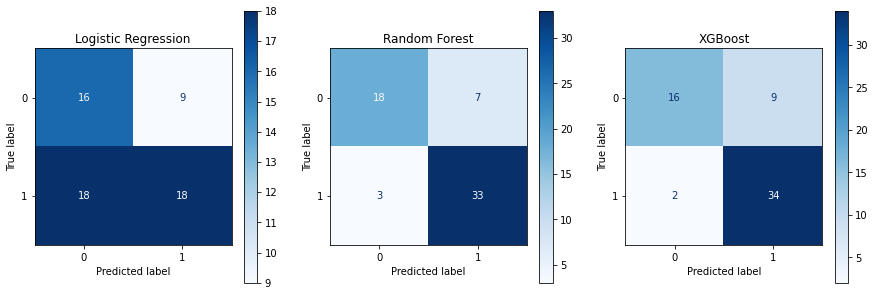

In [17]:
# Print classification reports for each model
print('Logistic Regression:')
print(classification_report(y_test, lr_pred))

print('Random Forest:')
print(classification_report(y_test, rf_pred))

print('XGBoost:')
print(classification_report(y_test, xgb_pred))

# Plot confusion matrices for each model
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
axs[0].set_title('Logistic Regression')
ConfusionMatrixDisplay.from_estimator(lr_model, X_test, y_test, ax=axs[0], cmap=plt.cm.Blues, normalize=None)

axs[1].set_title('Random Forest')
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, ax=axs[1], cmap=plt.cm.Blues, normalize=None)

axs[2].set_title('XGBoost')
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test, ax=axs[2], cmap=plt.cm.Blues, normalize=None)

plt.show()

### Classification Model for new dataset

In [21]:
# data preparation
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_new.drop(['id', 'label', 'tags'], axis=1), df_new['label'], test_size=0.2, random_state=42)
X_train.shape

(233, 27)

In [19]:
# model training
# Train the Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Train the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Train the XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

Logistic Regression:
              precision    recall  f1-score   support

           0       0.56      0.23      0.32        22
           1       0.66      0.89      0.76        37

    accuracy                           0.64        59
   macro avg       0.61      0.56      0.54        59
weighted avg       0.62      0.64      0.60        59

Random Forest:
              precision    recall  f1-score   support

           0       0.40      0.27      0.32        22
           1       0.64      0.76      0.69        37

    accuracy                           0.58        59
   macro avg       0.52      0.51      0.51        59
weighted avg       0.55      0.58      0.55        59

XGBoost:
              precision    recall  f1-score   support

           0       0.35      0.27      0.31        22
           1       0.62      0.70      0.66        37

    accuracy                           0.54        59
   macro avg       0.49      0.49      0.48        59
weighted avg       0.52      

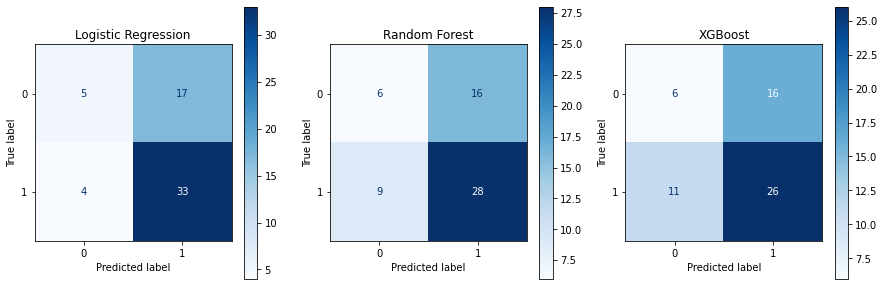

In [20]:
# Print classification reports for each model
print('Logistic Regression:')
print(classification_report(y_test, lr_pred))

print('Random Forest:')
print(classification_report(y_test, rf_pred))

print('XGBoost:')
print(classification_report(y_test, xgb_pred))

# Plot confusion matrices for each model
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
axs[0].set_title('Logistic Regression')
ConfusionMatrixDisplay.from_estimator(lr_model, X_test, y_test, ax=axs[0], cmap=plt.cm.Blues, normalize=None)

axs[1].set_title('Random Forest')
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, ax=axs[1], cmap=plt.cm.Blues, normalize=None)

axs[2].set_title('XGBoost')
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test, ax=axs[2], cmap=plt.cm.Blues, normalize=None)

plt.show()

In [2]:
# acc tags testing
#get accreditation tag from a single video id
from requests_html import HTMLSession, AsyncHTMLSession
from bs4 import BeautifulSoup as bs
def get_accreditation_tag(videoID, channel_id, acc_channel_list, no_acc_channel_list):
    try:
        search_url = "https://www.youtube.com/watch?v="
        video_url = search_url + videoID
        # print("Retrieving accTag for: ", video_url)
        #if the video belongs to a verified channel, return 1
        if (channel_id in acc_channel_list):
            return 1
        #if the video belongs to a non-verified channel, return 0
        if (channel_id in no_acc_channel_list):
            return 0
        print('Hi')
        # init an HTML Session
        session = HTMLSession()
        # get the html content
        response = session.get(video_url)
        response.html.render(scrolldown = 4, sleep=1, timeout=60)
        print('Hi')
        # create bs object to parse HTML
        soup = bs(response.html.html, "html.parser")
        acc_tag_text = soup.find_all("div", {"class":"content style-scope ytd-info-panel-content-renderer"})
        if(len(acc_tag_text) > 0):
            acc_tag = 1
            acc_channel_list.append(channel_id)
        else:
            acc_tag = 0
            no_acc_channel_list.append(channel_id)
    except:
        # print('error in extracting accTag')
        acc_tag = 0

    return acc_tag

In [3]:
videoID = 'aluv5CnAn0w'
channel_id = ''
acc_channel_list = []
no_acc_channel_list = []
get_accreditation_tag(videoID, channel_id, acc_channel_list, no_acc_channel_list)

Hi


0

In [7]:
async def get_html(url):
    session = AsyncHTMLSession()
    response = await session.get(url)
    await response.html.arender()
    return response.html

In [13]:
video_url = 'https://www.youtube.com/watch?v=aluv5CnAn0w'
a = await get_html(video_url)

Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error Target.detachFromTarget: Target closed.')>
pyppeteer.errors.NetworkError: Protocol error Target.detachFromTarget: Target closed.


Future exception was never retrieved
future: <Future finished exception=NetworkError('Protocol error (Target.sendMessageToTarget): No session with given id')>
pyppeteer.errors.NetworkError: Protocol error (Target.sendMessageToTarget): No session with given id


In [12]:
a

<coroutine object get_html at 0x7fdc593daf10>

In [11]:
soup = bs(a.html, "html.parser")
acc_tag_text = soup.find_all("div", {"class":"content style-scope ytd-info-panel-content-renderer"})

AttributeError: 'coroutine' object has no attribute 'html'

In [8]:
video_url = 'https://www.youtube.com/watch?v=aluv5CnAn0w'
# init an HTML Session
session = HTMLSession()
# get the html content
response = session.get(video_url)
response.html.render(scrolldown = 4, sleep=1, timeout=60)

RuntimeError: Cannot use HTMLSession within an existing event loop. Use AsyncHTMLSession instead.

In [5]:
!pip show httpx

Name: httpx
Version: 0.23.3
Summary: The next generation HTTP client.
Home-page: 
Author: 
Author-email: Tom Christie <tom@tomchristie.com>
License: 
Location: /opt/anaconda3/envs/ytbenv/lib/python3.10/site-packages
Requires: certifi, httpcore, rfc3986, sniffio
Required-by: 


In [17]:
import requests
from bs4 import BeautifulSoup

# Make an HTTP GET request to the YouTube video page
url = 'https://www.youtube.com/watch?v=aluv5CnAn0w'
response = requests.get(url)

response.html.render(scrolldown = 4, sleep=1, timeout=60)
soup = bs(response.html.html, "html.parser")

# Parse the HTML content using BeautifulSoup
# soup = BeautifulSoup(response.text, 'html.parser')

# Find the element with class "content style-scope ytd-info-panel-content-renderer"
elements = soup.find_all("div", {"class":"content style-scope ytd-info-panel-content-renderer"})
for element in elements:
    # Do something with the element
    print(element)

AttributeError: 'Response' object has no attribute 'html'

In [48]:
url = 'https://www.youtube.com/watch?v=aluv5CnAn0w'
url2 = 'https://www.youtube.com/watch?v=zFZrkCIc2Oc&list=PLhQjrBD2T380xvFSUmToMMzERZ3qB5Ueu&ab_channel=CS50'
url3 = "https://www.youtube.com/watch?v=mgFHUHVIx70"
response = requests.get(url3)
soup = BeautifulSoup(response.text, 'html.parser')
text = str(soup)
'clarify_box' in text

True

In [45]:
text

'<!DOCTYPE html>\n<html darker-dark-theme="" lang="en" style="font-size: 10px;font-family: Roboto, Arial, sans-serif;" system-icons="" typography="" typography-spacing=""><head><meta content="IE=edge" http-equiv="X-UA-Compatible"/><meta content="AlgsH67ctYlMR3JYAxEnGfvsoFo41AMqAg6wRHHXOpWAfD54ZCfTPBclxnFT4Gc8IUX4pq6Xfo0esDuOt+WH3wIAAABteyJvcmlnaW4iOiJodHRwczovL3lvdXR1YmUuY29tOjQ0MyIsImZlYXR1cmUiOiJQcml2YWN5U2FuZGJveEFkc0FQSXMiLCJleHBpcnkiOjE2ODA2NTI3OTksImlzU3ViZG9tYWluIjp0cnVlfQ==" http-equiv="origin-trial"/><script nonce="D96pWmHSjVJ6DTqXNbttOQ">var ytcfg={d:function(){return window.yt&&yt.config_||ytcfg.data_||(ytcfg.data_={})},get:function(k,o){return k in ytcfg.d()?ytcfg.d()[k]:o},set:function(){var a=arguments;if(a.length>1)ytcfg.d()[a[0]]=a[1];else for(var k in a[0])ytcfg.d()[k]=a[0][k]}};\nwindow.ytcfg.set(\'EMERGENCY_BASE_URL\', \'\\/error_204?t\\x3djserror\\x26level\\x3dERROR\\x26client.name\\x3d1\\x26client.version\\x3d2.20230309.08.00\');</script><script nonce="D96pWmHSjVJ6

In [34]:
# Save the HTML content to a file
with open('output.html', 'w') as file:
    file.write(soup.prettify())

In [51]:
def get_acc_tag(videoID, channel_id, acc_channel_list, no_acc_channel_list):
    try:
        search_url = "https://www.youtube.com/watch?v="
        video_url = search_url + videoID
        # print("Retrieving accTag for: ", video_url)
        #if the video belongs to a verified channel, return 1
        if (channel_id in acc_channel_list):
            return 1
        #if the video belongs to a non-verified channel, return 0
        if (channel_id in no_acc_channel_list):
            return 0
        response = requests.get(video_url)
        soup = BeautifulSoup(response.text, 'html.parser')
        text = str(soup)
        if 'clarify_box' in text:
            acc_tag = 1
        else:
            acc_tag = 0
    except:
        acc_tag = 0

    return acc_tag

In [52]:
get_acc_tag('aluv5CnAn0w', '', [], [])

1